# 1. Simple Chatbot

## Setup

In [1]:
from dotenv import load_dotenv
load_dotenv() #OPENAI_API_KEY 
# import os
# print(os.environ.get("OPENAI_API_KEY"))

True

## Build a simple Chatbot

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


### Add a chat Node

In [4]:
import os
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4.1")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

### Build the graph

In [5]:
graph_builder = StateGraph(State)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_node("chatbot", chatbot)
chatbot_graph = graph_builder.compile()

### Visualize the Graph

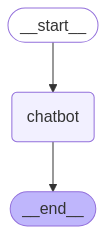

In [6]:
from IPython.display import Image, display
display(Image(chatbot_graph.get_graph().draw_mermaid_png()))

### Test - Chat with the bot

In [8]:
def stream_graph_updates(user_input: str):
    for event in chatbot_graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  what do you know about langgraph?


Assistant: **LangGraph** is an open-source framework released in early 2024 for building **stateful, multi-agent language model applications**. It was created by the team behind [LangChain](https://www.langchain.com/), and is intended to help developers build complex applications powered by large language models (LLMs) where **multiple agents (LLMs or tools) interact with each other** and can **retain state** across interactions.

## Key Features

- **Multi-Agent Workflows:** Easily orchestrates conversations and collaborative tasks between multiple "agents" (LLMs or function-calling endpoints).
- **State Management:** Explicitly models and manages the *state* of the application as it progresses, allowing for more complex, persistent logic than simple chains or flows.
- **Graph-Based Architecture:** Applications are represented as graphs where nodes are agents or states, and edges define transitions based on outputs, similar to state machines.
- **Looping & Branching:** Supports iterat

User:  quit


Goodbye!


## Chatbot with Tool use

In [11]:
!pip install -U langchain-tavily

In [15]:
load_dotenv() #for TAVILY_API_KEY 

True

### Add web search tool

In [12]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=5)

# list of all tools we want the LLM to use 
tools = [tool]
tool.invoke("What's a 'conditional edge' in LangGraph?")

{'query': "What's a 'conditional edge' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'LangGraph conditional edges - YouTube',
   'url': 'https://www.youtube.com/watch?v=EKxoCVbXZwY',
   'content': 'In LangGraph, we can use conditional edges in our flow engineering to control the flow based on some conditions. In this video, we use conditional edges to build a cycle and wait until a file is',
   'score': 0.88822687,
   'raw_content': None},
  {'title': 'LangGraph for Beginners, Part 3: Conditional Edges - Medium',
   'url': 'https://medium.com/ai-agents/langgraph-for-beginners-part-3-conditional-edges-16a3aaad9f31',
   'content': 'Learn about AI Agents, Multi Agents framework using langchain and langgraph In this article, we will create a simple graph that explains conditional edges in LangGraph. In the previous articles we discussed, we learnt how to create a simple graph and call LLM. We will create a simple graph, that forecasts 

In [20]:
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [61]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AI Message."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        # relies on the LLM's tool_calling support
        # so important to use LLMs like OpenAI, Claude and Gemini
        # that support tool calling
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [62]:
graph_with_tool = StateGraph(State)
graph_with_tool.add_edge(START, "chatbot")
graph_with_tool.add_node("chatbot", chatbot)
# use the tool node we just build
tool_node = BasicToolNode(tools=[tool])
graph_with_tool.add_node("tools", tool_node)
chatbot_with_tool = graph_with_tool.compile()

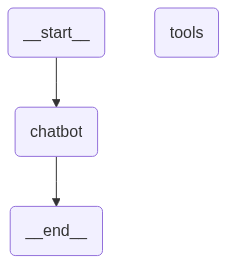

In [67]:
display(Image(chatbot_with_tool.get_graph().draw_mermaid_png()))

### Define conditional Edges (tools to chatbot)

In [68]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

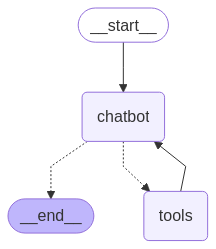

In [69]:
chatbot_with_tool = StateGraph(State)
chatbot_with_tool.add_node("chatbot", chatbot)
chatbot_with_tool.add_edge(START, "chatbot")
chatbot_with_tool.add_edge("chatbot", END)

tool_node = BasicToolNode(tools=[tool])
chatbot_with_tool.add_node("tools", tool_node)

chatbot_with_tool.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)

chatbot_with_tool.add_edge("tools", "chatbot")
final_graph = chatbot_with_tool.compile()

display(Image(final_graph.get_graph().draw_mermaid_png()))

## Using Prebuilt

In [15]:
from langgraph.prebuilt import ToolNode, tools_condition

# use prebuilt to build the tool node 
tool_node = ToolNode(tools=[tool])

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

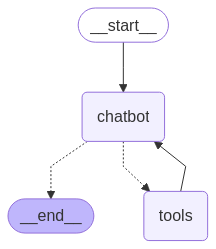

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def stream_graph_updates(user_input: str, graph):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input, graph)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  how can we create a toolcall node in langgraph?


Assistant: Sure! In **LangGraph** (often used with LangChain, Python), a "toolcall node" is a node that, when reached during execution, triggers a **tool** — for example, a function, API, or any external utility, and incorporates its result into the graph.

LangGraph is an orchestrator for LLM workflows as a graph. Nodes are typically functions or chain-like components, and a "toolcall node" is simply a node that *calls a tool*.

Here's how you can create a basic toolcall node in LangGraph (as of early 2024):

---

### 1. Define your tool (function):

```python
def search_tool(query: str) -> str:
    # Simulating a search tool
    return f"Searched for: {query}"
```

### 2. Build the LangGraph

Suppose you're using LangGraph like this:

```python
from langgraph.graph import StateGraph, END

# Optional: define your graph state as a dataclass
from dataclasses import dataclass

@dataclass
class GraphState:
    question: str
    result: str = ""

# Node that triggers the tool
def search_no